In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
import xgboost as xgb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Ganti path dengan path ke file di Google Drive Anda
file_path = '/content/drive/My Drive/Colab Notebooks/credit_card_balance.csv'
df = pd.read_csv(file_path)

# Validasi dataset
if df.empty:
    raise ValueError("Dataset kosong. Pastikan file 'credit_card_balance.csv' memiliki data.")
print("Kolom dalam dataset:", df.columns)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Kolom dalam dataset: Index(['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
       'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
       'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
       'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
       'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM', 'NAME_CONTRACT_STATUS', 'SK_DPD',
       'SK_DPD_DEF'],
      dtype='object')


In [ ]:
# Drop mostly-empty columns
df = df.dropna(thresh=len(df)*0.5, axis=1)

In [ ]:
# Fill missing
df = df.fillna(df.median(numeric_only=True))

In [ ]:
# Encode categoricals
for col in df.select_dtypes('object'):
    df[col] = pd.factorize(df[col])[0]

In [ ]:
# Create simulated target if 'TARGET' column doesn't exist
if 'TARGET' not in df.columns:
    try:
        df['TARGET'] = ((df['DAYS_CREDIT'] < -1000) & (df['AMT_CREDIT_MAX_OVERDUE'] > 0)).astype(int)
    except KeyError:
        print("Kolom 'DAYS_CREDIT' atau 'AMT_CREDIT_MAX_OVERDUE' tidak ditemukan. Membuat target simulasi alternatif.")
        df['TARGET'] = np.random.randint(0, 2, size=len(df))  # Target acak 0 atau 1
        # Atau gunakan logika lain yang sesuai dengan dataset Anda
    print("Kolom 'TARGET' telah dibuat secara simulasi.")

Kolom 'DAYS_CREDIT' atau 'AMT_CREDIT_MAX_OVERDUE' tidak ditemukan. Membuat target simulasi alternatif.
Kolom 'TARGET' telah dibuat secara simulasi.


In [ ]:
# Define features and target
if 'SK_ID_CURR' in df.columns:
    X = df.drop(['SK_ID_CURR', 'TARGET'], axis=1)
else:
    X = df.drop(['TARGET'], axis=1)
y = df['TARGET']

In [ ]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# --- Model 1: Logistic Regression ---
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_logreg))
print("AUC:", roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1]))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.50      0.67      0.57    384198
           1       0.50      0.33      0.40    383865

    accuracy                           0.50    768063
   macro avg       0.50      0.50      0.48    768063
weighted avg       0.50      0.50      0.48    768063

AUC: 0.49937522948369834


In [ ]:
# --- Model 2: Random Forest with GridSearch ---
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'max_samples': [0.0008, 0.0005] # Menambahkan max_samples untuk membatasi penggunaan dataset
}
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rf, param_grid, cv=3, scoring='roc_auc')
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("Random Forest (Tuned):")
print(classification_report(y_test, y_pred_rf))
print("AUC:", roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]))

Random Forest (Tuned):
              precision    recall  f1-score   support

           0       0.50      0.54      0.52    384198
           1       0.50      0.46      0.48    383865

    accuracy                           0.50    768063
   macro avg       0.50      0.50      0.50    768063
weighted avg       0.50      0.50      0.50    768063

AUC: 0.4995418323211376


In [ ]:
# --- Model 3: XGBoost ---
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
print("XGBoost:")
print(classification_report(y_test, y_pred_xgb))
print("AUC:", roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1]))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:23:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost:
              precision    recall  f1-score   support

           0       0.50      0.53      0.52    384198
           1       0.50      0.47      0.48    383865

    accuracy                           0.50    768063
   macro avg       0.50      0.50      0.50    768063
weighted avg       0.50      0.50      0.50    768063

AUC: 0.5001309660181397


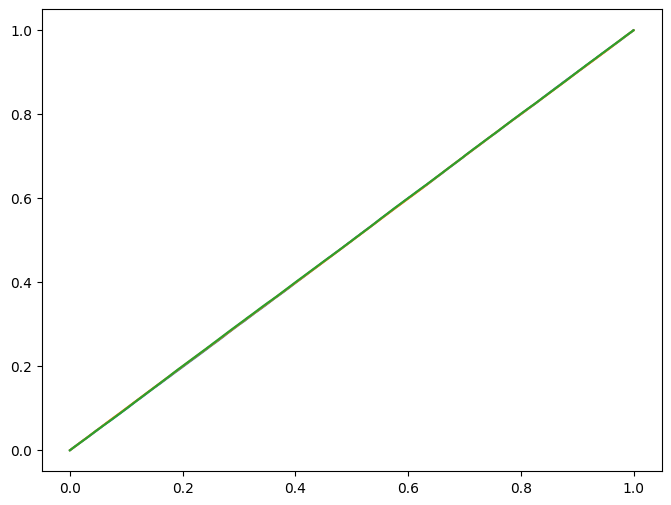

In [ ]:
# --- Visualize ROC Curve ---
plt.figure(figsize=(8,6))
for name, model in zip(
    ['Logistic Regression', 'Random Forest', 'XGBoost'],
    [logreg, best_rf, xgb_clf]
):
    try:
        fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, model.predict_proba(X_test)[:,1]):.2f})")
    except Exception as e:
        print(f"Error plotting ROC for {name}: {e}")

<ipython-input-29-9aada1a94158>:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


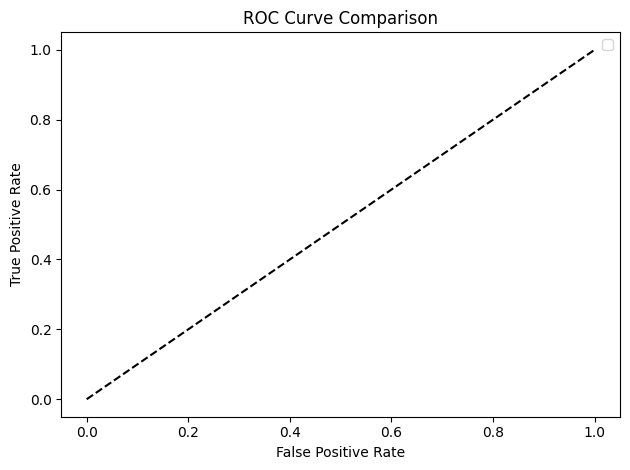

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.show()